# Finding Star Clusters in Gaia data with Pandas and Scikit-Learn


## Introduction

Young star clusters and stellar associations are important sites for understanding the stellar birth environment and stellar evolution. The Gaia mission will provide the 3D location and proper motions for over 1 billion stars, making it the perfect telescope to discover new star clusters and further characterize known clusters.

This activity uses a piece of the initial Gaia data release as input for a machine learning clustering algorithm to identify stellar overdensities. 


For this notebook, we're using [NumPy](http://www.numpy.org), [Matplotlib](https://matplotlib.org), [Pandas](http://pandas.pydata.org), [Scikit-learn](http://scikit-learn.org/stable/), and [Astropy](http://www.astropy.org). If you don't have these you can install them with [pip](https://packaging.python.org/installing/). On the commmand line type:
~~~~
pip install --upgrade numpy
pip install --upgrade astropy
pip install --upgrade scikit-learn
pip install --upgrade pandas
pip install --upgrade matplotlib
~~~~

## The Data
This dataset combines Hipparcos and Tycho-2 data with new Gaia observations to provide accurate 3D positions and proper motions on the sky -- no radial velocities yet, though!

All of the data can be downloaded in chunks from the Gaia website, [here](http://cdn.gea.esac.esa.int/Gaia/tgas_source/). A description of all of the columns can be found [here](https://gaia.esac.esa.int/documentation/GDR1/datamodel/Ch1/tgas_source.html).

I've taken the relevant columns and put everything into a Pandas DataFrame. This is compactly stored in the HDF5 data file, alldata.hdf, which you should download from [here](http://doi.org/10.5281/zenodo.569876) and place in this directory (note that the file is 285 MB). 

Load the data by reading it in with Pandas,

In [132]:
import pandas as pd
dat  = pd.read_hdf('alldata.hdf')

You can think of this simple Pandas DataFrame as a large table which has built in functions to process rows and columns, read and write to many different formats on disk, and interact with other DataFrames.

Try printing the DataFrame to see a small sample.

In [133]:
print(dat)

                 source_id  ref_epoch          ra  ra_error       dec  \
0            7627862074752     2015.0   45.034330  0.305989  0.235392   
1            9277129363072     2015.0   45.165007  2.583882  0.200068   
2           13297218905216     2015.0   45.086155  0.213836  0.248825   
3           13469017597184     2015.0   45.066542  0.276039  0.248211   
4           15736760328576     2015.0   45.136038  0.170697  0.335044   
5           16527034310784     2015.0   45.141378  0.205008  0.359618   
6           16733192740608     2015.0   45.152959  0.189524  0.386343   
7           16870631694208     2015.0   45.112779  0.206981  0.380844   
8           26834955821312     2015.0   45.010270  0.243576  0.351099   
9           33260226885120     2015.0   44.974659  0.267911  0.473472   
10          44358422235136     2015.0   45.501447  0.134010  0.497704   
11          51745765982848     2015.0   45.467165  0.146028  0.655080   
12          82463372227072     2015.0   44.866247  

We see that we have 2,057,050 stars in our dataset, each of which has a measured position on the sky (both (ra,dec) and (l,b)), a parallax, a G band magnitude, and proper motion on the sky (pmra,pmdec). Each of these measurements also has an error associated with it. 

We can see how much memory our DataFrame object is taking up with,

In [134]:
print('{:d} rows'.format(len(dat)))
print('{:.1f} MB'.format(dat.memory_usage(index=True,deep=True).sum()/1e6))

2057050 rows
296.2 MB


We can try reducing this by only loading in the columns we'll be working with.

In [135]:
dat  = pd.read_hdf('alldata.hdf',columns=['ra','ra_error','dec','dec_error','parallax','parallax_error'])
print('{:d} rows'.format(len(dat)))
print('{:.1f} MB'.format(dat.memory_usage(index=True,deep=True).sum()/1e6))
print(dat)

2057050 rows
115.2 MB
               ra  ra_error       dec  dec_error   parallax  parallax_error
0       45.034330  0.305989  0.235392   0.218802   6.352951        0.307910
1       45.165007  2.583882  0.200068   1.197789   3.900329        0.323488
2       45.086155  0.213836  0.248825   0.180326   3.155313        0.273484
3       45.066542  0.276039  0.248211   0.200958   2.292367        0.280972
4       45.136038  0.170697  0.335044   0.170130   1.582077        0.261539
5       45.141378  0.205008  0.359618   0.179848   8.663080        0.255867
6       45.152959  0.189524  0.386343   0.171880   5.698205        0.263677
7       45.112779  0.206981  0.380844   0.150943   2.090812        0.222206
8       45.010270  0.243576  0.351099   0.169345   6.202492        0.247253
9       44.974659  0.267911  0.473472   0.163531   1.677673        0.222067
10      45.501447  0.134010  0.497704   0.395606   9.957504        0.547771
11      45.467165  0.146028  0.655080   0.151794   5.032630       

We cut the size of our DataFrame in half!

### Pandas indexing

One thing that makes pandas great for analyzing large datasets is the way it stores the data. Rather than using a normal list or numpy array, pandas uses a hashtable to quickly find a particular row of the data. We can see the keys for this hashtable as the row numbers when we print our pandas DataFrame object. 

We can see all of these indices for our DataFrame by accessing the index attribute of the DataFrame,


In [136]:
print(dat.index)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            34065, 34066, 34067, 34068, 34069, 34070, 34071, 34072, 34073,
            34074],
           dtype='int64', length=2057050)


So pandas uses a list of integers to label the rows of our data. We can get a little more information by sorting this list before printing it,

In [137]:
import numpy as np
print(np.sort(dat.index))

[     0      0      0 ..., 134864 134864 134864]


Hold on, something doesn't look quite right. We have duplicate indices for different rows of our data! This is one thing we have to careful about when we feed pandas a large dataset -- the hashtable may have non-unique keys. 

Luckily, we can fix this by simply recalculating the indices after we load our data,

In [138]:
dat  = pd.read_hdf('alldata.hdf',columns=['ra','ra_error','dec','dec_error','parallax','parallax_error'])
dat = dat.reset_index()
dat.index

RangeIndex(start=0, stop=2057050, step=1)

It looks like we have unique indices now!

Now we can move on to visualizing our data.

### Visualizing our data
The DataFrame object contains some built-in convienence functions for quickly getting a sense of your data. For example, we can quickly make histograms of different columns with the dat.hist() method,

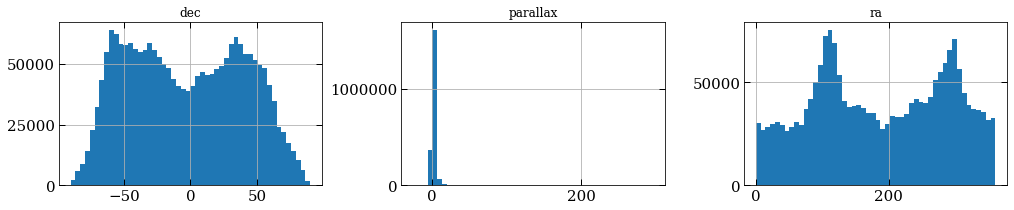

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,axes = plt.subplots(1,3,figsize=(17,3))
dat.hist(['ra','dec','parallax'],ax=axes,xlabelsize=15,ylabelsize=15,bins=50);

We can see right away that Gaia is an all sky survey as it covers the full range of right ascension and declination. The parallax histogram looks a little funny though. There seems to be some bad parallax data that we should remove before proceeding. Remember that parallax is related to distance via

$$\text{distance in pc} = 1 / (\text{parallax in arcsec}) .$$

The Gaia parallaxes are reported in milliarcsec, and so the distances will be in kpc. From looking at the histogram for parallax we see two problems. The first is there are a number of negative parallaxes. We can verify this by slicing our DataFrame object to only show the rows where the parallax is negative,

In [142]:
print(dat[dat.parallax<0])

         index          ra  ra_error        dec  dec_error  parallax  \
783        783   45.515296  0.141345   5.989946   0.346414 -0.012890   
810        810   44.974303  0.520221   6.200443   0.414850 -0.014806   
1031      1031   51.650489  0.814994   5.706888   0.612814 -1.407067   
1245      1245   51.340087  0.691294   8.748267   0.362725 -0.298734   
2443      2443   37.129398  0.831394  10.069239   0.399300 -0.133778   
3822      3822   46.991066  0.629890  16.730952   0.225115 -0.224989   
3897      3897   43.298678  0.480449  16.169881   0.374759 -0.111915   
4086      4086   56.877414  1.169436  11.461870   0.508449 -0.572870   
4191      4191   55.527342  0.449842  11.467865   0.161759 -0.261065   
4530      4530   56.914127  0.668079  14.841630   0.171766 -2.472477   
4988      4988   55.946968  0.942106  16.561471   0.226408 -0.291551   
5100      5100   54.796546  0.780839  16.734744   0.398559 -0.532618   
5270      5270   55.769354  0.439302  19.020534   0.217892 -0.32

We can remove these by using the dat.drop() method,

2026210 rows
129.7 MB


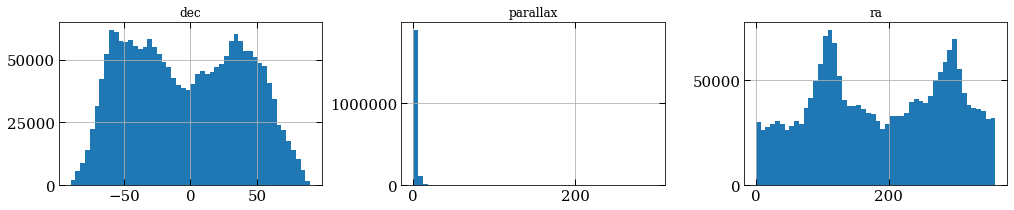

In [143]:
dat = dat.drop(dat[dat.parallax < 0].index)
print('{:d} rows'.format(len(dat)))
print('{:.1f} MB'.format(dat.memory_usage(index=True,deep=True).sum()/1e6))
fig,axes = plt.subplots(1,3,figsize=(17,3))
dat.hist(['ra','dec','parallax'],ax=axes,xlabelsize=15,ylabelsize=15,bins=50);

Looks better. 

Note that if we forgot to reset our DataFrame indices with dat.reset_index() earlier, then calling the dat.drop() method would have removed all of the duplicate rows that shared an index with one of the negative parallax entries! 

Next, we have a few parallaxes which are relatively large and are skewing our histogram. We can verify this by sorting our rows by descending parallax,

In [144]:
dat.sort_values('parallax',ascending=False)

,index,ra,ra_error,dec,dec_error,parallax,parallax_error
1035691,91636,176.937519,0.462309,0.799460,0.281370,295.803638,0.535664
636544,97084,280.683855,0.920717,59.634628,0.292361,286.391028,0.832375
636545,97085,280.683792,0.389218,59.637860,0.301627,283.536922,0.407929
94182,94182,4.612109,0.287586,44.024673,0.367812,280.740075,0.305500
1976175,88065,319.296181,0.368213,-38.872138,0.370400,251.138192,0.568683
1157706,78786,247.574841,0.420255,-12.667522,0.251275,232.285621,0.487817
377161,107431,264.104293,0.445606,68.333850,0.405466,220.024758,0.393103
1431397,82747,176.454907,0.178622,-64.842957,0.222308,215.782333,0.272784
733609,59284,343.323837,0.881040,-14.266502,0.789781,214.051333,0.970971
1972089,83979,323.391271,0.234962,-49.012404,0.297190,201.118291,0.511675


A parallax of ~300 mas corresponds to a distance of about 3 pc. So these stars are very close to the Sun. We'll be primarily interested in stars that are >40 pc away, so let's drop any stars closer than 20 pc. 

2025681 rows
129.6 MB


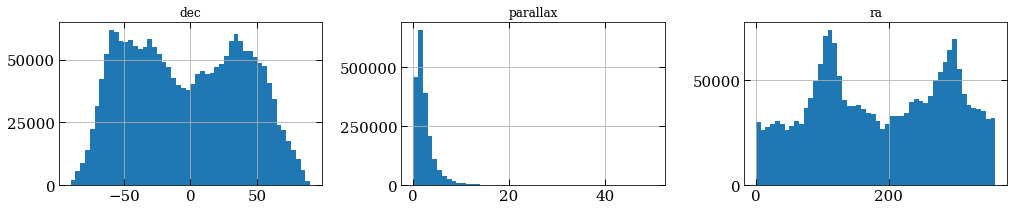

In [145]:
dat = dat.drop(dat[1./dat.parallax < 0.02].index)
print('{:d} rows'.format(len(dat)))
print('{:.1f} MB'.format(dat.memory_usage(index=True,deep=True).sum()/1e6))
fig,axes = plt.subplots(1,3,figsize=(17,3))
dat.hist(['ra','dec','parallax'],ax=axes,xlabelsize=15,ylabelsize=15,bins=50);

We could have also made these two cuts to our data at the same time


2025681 rows
129.6 MB


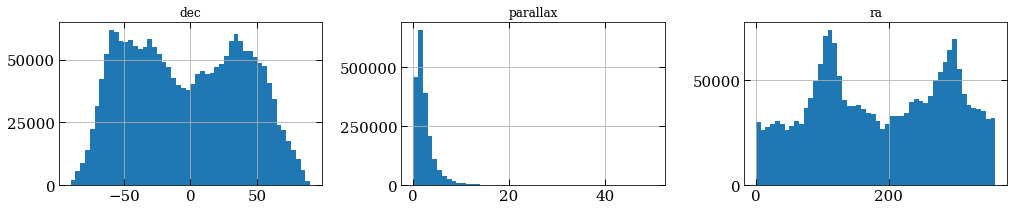

In [146]:
dat  = pd.read_hdf('alldata.hdf',columns=['ra','ra_error','dec','dec_error','parallax','parallax_error']).reset_index()
bad_indices = dat.parallax < 0   # Negative parallax indices
bad_indices = bad_indices | (1./dat.parallax < .02)  # OR operation with distances less than 30 pc
dat = dat.drop(dat[bad_indices].index)


print('{:d} rows'.format(len(dat)))
print('{:.1f} MB'.format(dat.memory_usage(index=True,deep=True).sum()/1e6))
fig,axes = plt.subplots(1,3,figsize=(17,3))
dat.hist(['ra','dec','parallax'],ax=axes,xlabelsize=15,ylabelsize=15,bins=50);

## Finding some known clusters

Now that we have our data, let's find some clusters! Our procedure will be,
* Input the (ra,dec,distance) position of a known star cluster.
* Find the Gaia data within a few degrees of that.
* Use a clustering algorithm to find the cluster (and any other clusters) in that field. 

To save some time, I've coded up a Python class to hold all of the useful information and methods for a known star cluster. You should take some time to get a sense for how the class works. The class does several things:

* Given the (ra,dec,distance) position of the cluster, it uses Astropy to convert this into a Galactocentric position, which we'll use to compare stellar positions in real space, as opposed to just on the sky.

* The method `.lims()`, will calculate which of the given stars lies within a certain distance of the cluster center. You can see that it uses similar slicing operations that we saw earlier to return a subset of the data.

* The method `.plot_field()` will make a scatter plot of the local field on the sky.



In [11]:
from astropy import units
import astropy.coordinates as coord
import numpy as np
class Cluster(): 
    def __init__(self,name,ra,dec,distance,size):
        """Initialize a cluster with the (ra,dec,distance) center and radial size."""
        self.name = name
        self.distance = distance
        self.coord = coord.SkyCoord(ra=[ra],dec=[dec],distance=[distance]*units.kpc)
        self.pos = (self.coord.ra[0]/units.deg,self.coord.dec[0]/units.deg)
        self.posg = self.coord.transform_to(coord.Galactocentric)
        self.posg = (self.posg.x[0]/units.kpc, self.posg.y[0]/units.kpc,self.posg.z[0]/units.kpc)
        self.size = size
        self.sizeg = np.deg2rad(self.size)*self.coord.distance[0]/units.kpc
        
    def lims(self,dat,nrad=5,sphere=True):
        if sphere:
            
            ind = (abs(dat.ra-self.pos[0])<self.size*nrad)&(abs(dat.dec - self.pos[1])<self.size*nrad)
            ind_dist = abs(1./dat.parallax * (1 + dat.parallax_error/dat.parallax) - self.distance) < .5*self.distance
            ind_dist |= ( abs(1./dat.parallax * (1 - dat.parallax_error/dat.parallax) - self.distance) < .5*self.distance)
            ind &= ind_dist
            print('{:d} objects in {:d} degree radius'.format(len(dat.ra[ind]),nrad))
        else:
            ind = (abs(dat.x - self.posg[0])<self.sizeg*nrad)&(abs(dat.y - self.posg[1])<self.sizeg*nrad)&(abs(dat.z - self.posg[2])<self.sizeg*nrad)
            print('{:d} objects in projected {:.1f} pc radius'.format(len(dat.ra[ind]),self.sizeg*nrad))
        return ind
    def plot_field(self,dat,nrad=5,sphere=True):
        ind = self.lims(dat,nrad,sphere)
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.tick_params(labelsize=15)
        img=ax.scatter(dat.ra[ind],dat.dec[ind],c=1e3/dat.parallax[ind],s=6,cmap='jet')
        ax.set_title('{}  D={:d} pc'.format(self.name,int(self.distance*1e3)),fontsize=20)
        ax.plot(self.pos[0],self.pos[1],'k*',ms=20)
        x = np.linspace(0,2*np.pi,100)
        ax.plot(self.pos[0] + self.size*np.cos(x),self.pos[1] + self.size* np.sin(x),'--k')
        cbar = plt.colorbar(img)
        cbar.ax.set_ylabel('Distance [pc]',fontsize=20)
        cbar.ax.tick_params(labelsize=15)
        ax.set_xlabel('Right Ascension [degrees]',fontsize=20)
        ax.set_ylabel('Declination [degrees]',fontsize=20)

Let's take the <a href="https://en.wikipedia.org/wiki/Hyades_(star_cluster)">Hyades</a> cluster is our first example. The Hyades is roughly located at (ra,dec,distance) = (4h27m,+15d52m,47 pc), and is ~330 arcmin in size. 

Load in the Hyades and show the star field around its position on the sky.

998 objects in 5 degree radius


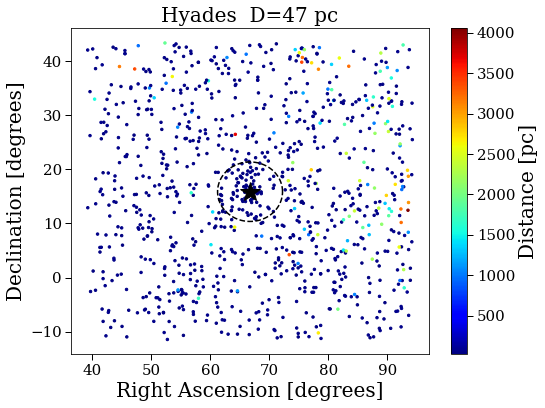

In [12]:
hyades=Cluster('Hyades','4h27m','+15d52m',.047,330./60.)
hyades.plot_field(dat)

Let's also load in the <a href="https://en.wikipedia.org/wiki/Pleiades">Pleiades</a>, <a href="https://en.wikipedia.org/wiki/Beehive_Cluster">Beehive</a>, <a href="https://en.wikipedia.org/wiki/Coma_Star_Cluster">Coma</a>, <a href="https://en.wikipedia.org/wiki/Alpha_Persei_Cluster">Alpha Persius</a> clusters,

1571 objects in 5 degree radius
2185 objects in 5 degree radius
6433 objects in 5 degree radius
6974 objects in 5 degree radius


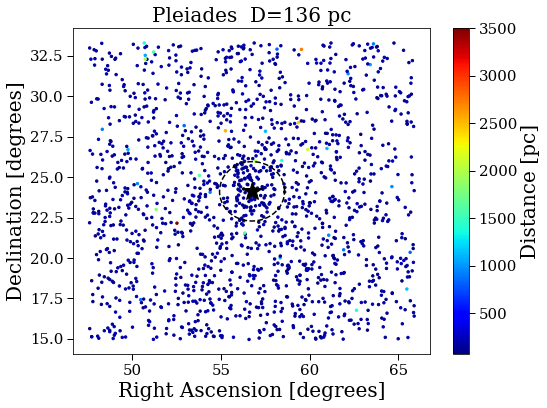

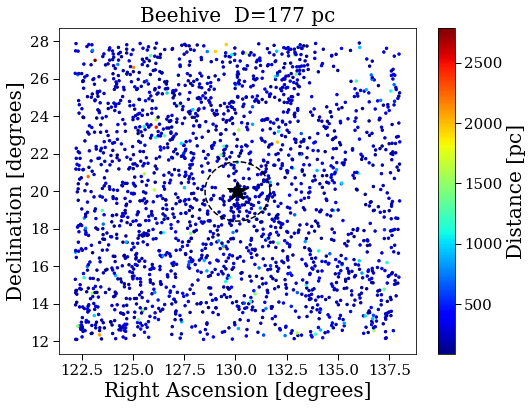

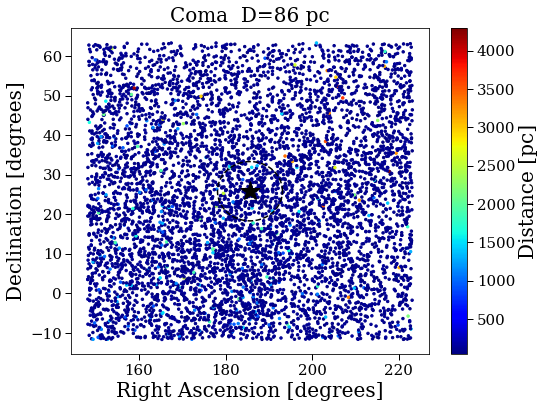

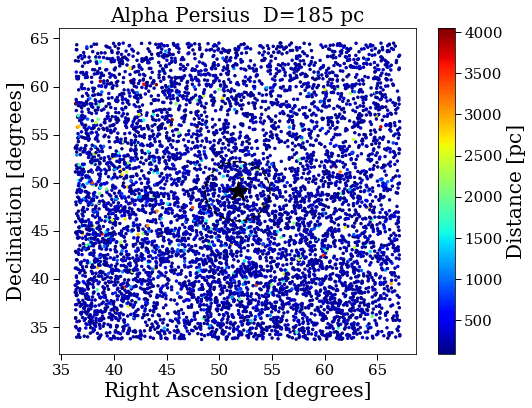

In [13]:
pleiades = Cluster('Pleiades','3h47m','+24d07m',.1362,110./60)
pleiades.plot_field(dat)
beehive = Cluster('Beehive','08h40.4m','19d59m',.177,95./60)
beehive.plot_field(dat)
coma = Cluster('Coma','12h22.5m','+25d51m',.086,7.5)
coma.plot_field(dat)
alphaper = Cluster('Alpha Persius','03h26.9m','+49d07m', .5*(.171+.200),185./60.)
alphaper.plot_field(dat)

## The Algorithm
Now that we have our star fields, let's figure out how we're going deterime which stars are a part of a cluster. The basic idea will be to identify regions which are more dense (in phase space) than their surroundings. There are many different algorithms for doing this, and each has their advantages and weaknesses. 

Grouping similar things together is a common task in [machine learning](https://en.wikipedia.org/wiki/Cluster_analysis), and we'll borrow the tools and techniques from that field for our analysis. In particular, we'll be using the popular [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) algorithm. 

DBSCAN works as follows. For every point in your dataset DBSCAN will search in a radius of $\epsilon$ for $N$ points. If there are at least $N$ points within this distance, then these points start a cluster. DBSCAN then goes through all of the other data points and looks within a ball of radius $\epsilon$ for $N$ more points. If any of these regions overlap, the clusters are merged. DBSCAN continues to do this until all points are either a part of a cluster, or are a part of the background noise. Here's a simple schematic of how this looks for $N=4$,

<img src="dbscan.png">


Luckily for us, the Python library [Scikit-learn](http://scikit-learn.org/stable/) has implemented DBSCAN in its [clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering) module. You can read the documentation for how to use DBSCAN [here](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN). 

I've written some wrapper functions (modified from the DBSCAN example) to find all of the clusters with `min_samples` in a radius of `eps`, and to plot the results in several differnt ways.

In [14]:
from astropy.coordinates import Distance
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import DBSCAN
def get_clusters(pos,eps=.005,min_samples=20,sphere=True):   
    if sphere:
        print('Requiring that there are {:d} neighbors in a {:.1f} degree radius '.format(min_samples, np.rad2deg(eps)))
        print('Using haversine 2D distance on sky')
        dist= DistanceMetric.get_metric('haversine').pairwise(pos[:,:2])
    else:
        print('Requiring that there are {:d} neighbors in a {:.1f} pc radius '.format(min_samples, eps*1e3))
        print('Using Euclidean 3D distance')
        dist= DistanceMetric.get_metric('euclidean').pairwise(pos)
    db = DBSCAN(eps=eps, min_samples=min_samples,metric='precomputed').fit(dist)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    return labels,core_samples_mask
def cluster_distances(pos,labels,core_samples_mask,known_clusters=None,sphere=True,top='all',ax=None,fig=None):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = np.unique(labels)
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,6))
    if not sphere:
        print('Please use the ra/dec coordinates')
        return
    counts = np.array([len(labels[labels == k]) for k in unique_labels])
    cinds = np.argsort(counts)[::-1]    
    unique_labels = unique_labels[cinds]
    if top == 'all':
        top = len(unique_labels+1)
    else:
        top += 1
    colors = plt.cm.Vega10(np.linspace(0, 1, len(unique_labels[:top])))
    for k, col in zip(unique_labels[:top], colors):
        if k != -1:
            class_member_mask = (labels == k)
            d = pos[class_member_mask &core_samples_mask,-1]
            nc = len(d)
            if nc>1:
                lbl='{:d} Members'.format(nc)
            else:
                lbl = '1 Member'
            ax.hist(d*1e3,color=col,histtype='step',lw=3,label=lbl )
            ax.axvline(d.mean()*1e3,c=col,ls='--',lw=3)
    ax.set_xlabel('D [pc]',fontsize=20)
    ax.set_ylabel('Counts',fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend(loc='best',fontsize=15)
    if known_clusters is not None:
        for cluster in known_clusters:
            ax.axvline(cluster.distance*1e3,c='k',ls='--')
def plot_clusters(pos,labels, core_samples_mask,known_clusters=None,sphere=True,top='all',ax=None,fig=None):
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = np.unique(labels)
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,8))
    
    counts = np.array([len(labels[labels == k]) for k in unique_labels])
    cinds = np.argsort(counts)[::-1]    
    unique_labels = unique_labels[cinds]
    if top == 'all':
        top = len(unique_labels+1)
    else:
        top += 1
    colors = plt.cm.Vega10(np.linspace(0, 1, len(unique_labels[:top])))
    for k, col in zip(unique_labels[:top], colors):
        alpha = 1
        if k == -1:
            # Black used for noise.
            col = 'k'
            alpha = .2

        class_member_mask = (labels == k)
        
        xy = pos[class_member_mask & core_samples_mask,:2]

        if sphere:
            xy = np.rad2deg(xy)
        ax.scatter(xy[:, 0], xy[:, 1], c=col, s=20,alpha=alpha)
        
        xy = pos[class_member_mask & ~core_samples_mask,:2]
        
        if sphere:
            xy = np.rad2deg(xy)
        ax.scatter(xy[:, 0], xy[:, 1], c=col, s=2,alpha=alpha)
        if k != -1:
            ax.plot([xy[:,0].mean()],[xy[:,1].mean()],marker='+',c=col,ms=25,mew=5)
    ax.set_title('Estimated number of clusters: {:d}'.format(n_clusters_),fontsize=20)
   
    if known_clusters is not None:
        for cluster in known_clusters:
            x = np.linspace(0,2*np.pi,100)
            if sphere:
                ax.plot(cluster.pos[1] + cluster.size*np.cos(x) ,cluster.pos[0] + cluster.size*np.sin(x) ,'--k',lw=3)
                ax.plot([cluster.pos[1]],[cluster.pos[0]],'*',ms=12,c='k')
                ax.set_ylabel('Right Ascension [Degrees]',fontsize=20)
                ax.set_xlabel('Declination [Degrees]',fontsize=20)
     
            else:
                ax.plot(cluster.posg[0] + cluster.sizeg*np.cos(x) ,cluster.posg[1] + cluster.sizeg*np.sin(x) ,'--k',lw=3)
                ax.plot([cluster.posg[0]],[cluster.posg[1]],'*',ms=12,c='k')
                ax.set_xlim(cluster.posg[0]-cluster.sizeg*5,cluster.posg[0]+cluster.sizeg*5)
                ax.set_ylim(cluster.posg[1]-cluster.sizeg*5,cluster.posg[1]+cluster.sizeg*5)
                ax.set_ylabel('X [kpc]',fontsize=20)
                ax.set_xlabel('Y [kpc]',fontsize=20)
    ax.minorticks_on()
    
    ax.tick_params(labelsize=15)
   
    fig.tight_layout()
def plot_clusters3d(pos,labels, core_samples_mask,known_clusters=None,sphere=True,top='all',ax=None,fig=None):
    from mpl_toolkits.mplot3d import Axes3D
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = np.unique(labels)
    if ax is None:
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111,projection='3d')
    counts = np.array([len(labels[labels == k]) for k in unique_labels])
    cinds = np.argsort(counts)[::-1]    
    unique_labels = unique_labels[cinds]
    if top == 'all':
        top = len(unique_labels+1)
    else:
        top += 1
    colors = plt.cm.Vega10(np.linspace(0, 1, len(unique_labels[:top])))
    for k, col in zip(unique_labels[:top], colors):
        alpha = 1
        if k != -1:
            class_member_mask = (labels == k)

            xyz = pos[class_member_mask & core_samples_mask,:]

            if sphere:
                xyz[:,:2] = np.rad2deg(xyz[:,:2])
            ax.scatter(xyz[:, 0], xyz[:, 1],xyz[:,2], c=col, s=50,alpha=alpha)

            xyz = pos[class_member_mask & ~core_samples_mask,:]

            if sphere:
                xyz[:,:2] = np.rad2deg(xyz[:,:2])
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:,2],c=col, s=2,alpha=alpha)
            if k != -1:
                ax.plot([xyz[:,0].mean()],[xyz[:,1].mean()],[xyz[:,2].mean()],marker='+',ms=20,mew=8,c=col)
    ax.set_title('Estimated number of clusters: {:d}'.format(n_clusters_),fontsize=20)
    ax.set_xlabel('X [kpc]',fontsize=20,labelpad=20)
    ax.set_ylabel('Y [kpc]',fontsize=20,labelpad=20)
    ax.set_zlabel('Z [kpc]',fontsize=20,labelpad=20)
    
    ax.minorticks_on()
    
    ax.tick_params(labelsize=15)
   
    fig.tight_layout()    
def prepare_coords(dat,cluster,sphere=True,nrad=5):
    ind = cluster.lims(dat,nrad=nrad)
    pos = coord.SkyCoord(ra=np.array(dat.ra[ind])*units.degree,dec=np.array(dat.dec[ind])*units.degree,distance=np.array(1./dat.parallax[ind])*units.kpc,frame='icrs')
    if sphere:
        return np.vstack((np.deg2rad(np.array(pos.dec/units.deg)), np.deg2rad(np.array(pos.ra/units.deg)),np.array(pos.distance/units.kpc))).T
    else:
        pos = pos.transform_to(coord.Galactocentric)
        return np.vstack((np.array(pos.x/units.kpc), np.array(pos.y/units.kpc),np.array(pos.z/units.kpc))).T
def find_cluster(cluster,dat,eps=.005,min_samples=5,nrad=5,top=3):
    pos = prepare_coords(dat,cluster,nrad=nrad,sphere=False)
    labels, core_mask = get_clusters(pos,
                                     eps=eps,min_samples=min_samples,sphere=False)
    fig,axes = plt.subplots(1,2,figsize=(12,6))
    pos = prepare_coords(dat,cluster,nrad=nrad)
    plot_clusters(pos,labels, 
                  core_mask,known_clusters=[cluster],sphere=True,ax=axes[0],fig=fig,top=top)
    cluster_distances(pos,labels, 
                      core_mask,known_clusters=[cluster],sphere=True,ax=axes[1],fig=fig,top=top)
    fig.tight_layout()
def find_cluster3d(cluster,dat,eps=.005,min_samples=5,nrad=5,top=3):
    pos = prepare_coords(dat,cluster,nrad=nrad,sphere=False)
    labels, core_mask = get_clusters(pos,
                                     eps=eps,min_samples=min_samples,sphere=False)
    
    plot_clusters3d(pos,labels, 
                  core_mask,known_clusters=[cluster],sphere=False,top=top)
    

To use these you just need to call the `find_cluster(cluster,dat,eps,min_samples)` function, and specify `eps` and `min_samples`. The default values for these are 5 stars within 5 pc, but you should adjust them to see how they affect the final results. 

To start, let's look at the Hyades.

998 objects in 5 degree radius
Requiring that there are 5 neighbors in a 3.0 pc radius 
Using Euclidean 3D distance
998 objects in 5 degree radius


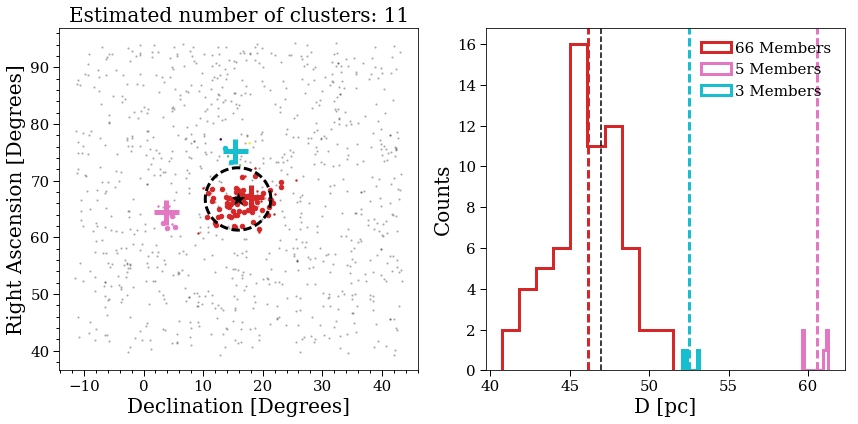

In [15]:
%matplotlib inline
find_cluster(hyades,dat,eps=.003) # 5 stars within 3 pc

DBSCAN found 9 clusters, and we're showing just the three largest ones. Each cluster has an associated color and is shown on the sky in the left plot. The center of mass is shown with a cross. The right plot shows the distribution of distances for each cluster, with the average distance shown by the dashed vertical line.  Stars that are not a part of a cluster are shown in grey. 

We can see that the largest cluster has 66 members and is roughly centered on the sky near the known location of the Hyades. Looking at the distances, we see that the distrubtion is centered close to the Hyades distance, and has a ~5 pc spread. The tidal radius of the Hyades is roughly ~10 pc, so these stars may actually be correctly classified. Note that the other clusers have < 5 members and are probably not signficant.

We can also use matplotlib's 3D plotting cababilities to see the cluster in 3D. For this we'll use the `%matplotlib notebook` magic to be able to manipulate the image. 

998 objects in 5 degree radius
Requiring that there are 5 neighbors in a 3.0 pc radius 
Using Euclidean 3D distance


<IPython.core.display.Javascript object>


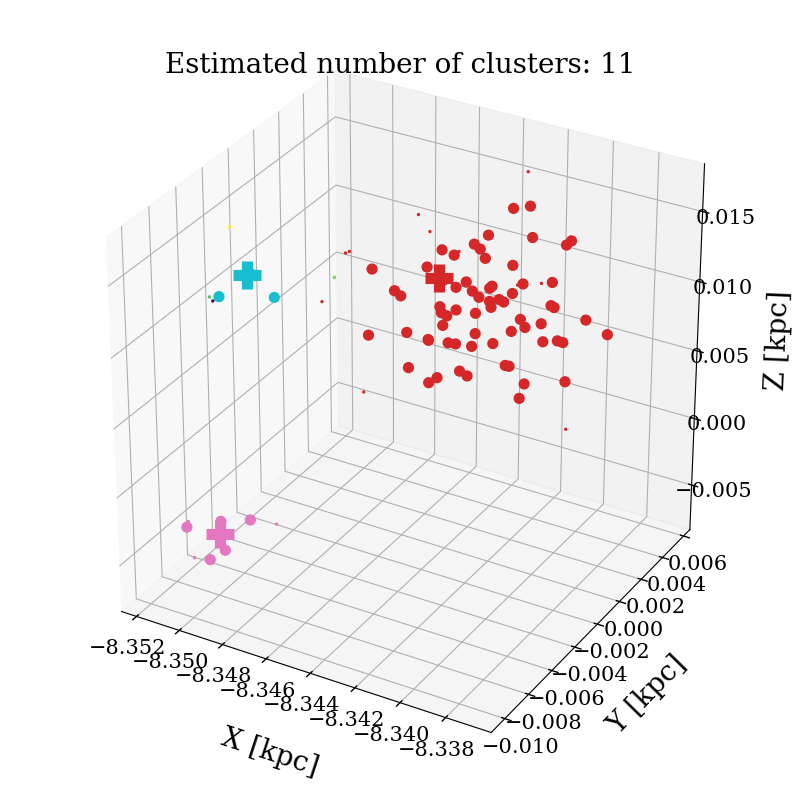

In [20]:
%matplotlib notebook 
# If the notebook interace doesn't show up, you made need to restart the kernel and run this cell
find_cluster3d(hyades,dat,eps=.003)

Next we'll do the Pleiades,


1571 objects in 5 degree radius
Requiring that there are 5 neighbors in a 3.5 pc radius 
Using Euclidean 3D distance
1571 objects in 5 degree radius


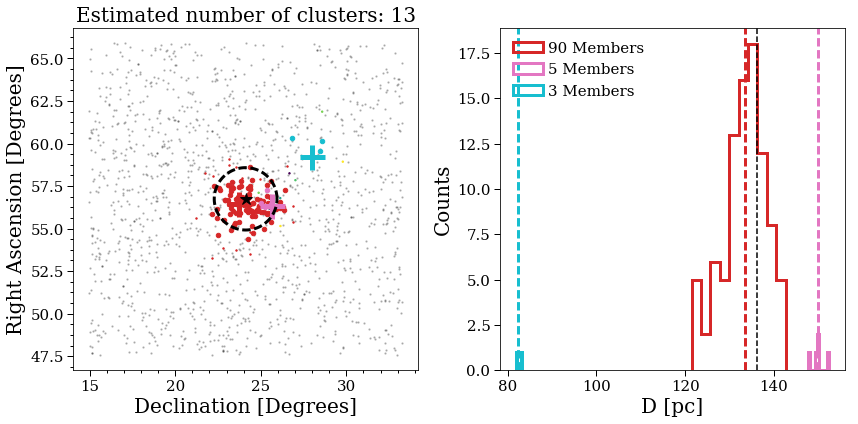

In [17]:
%matplotlib inline
find_cluster(pleiades,dat,eps=.0035)

1571 objects in 5 degree radius
Requiring that there are 5 neighbors in a 3.5 pc radius 
Using Euclidean 3D distance


<IPython.core.display.Javascript object>


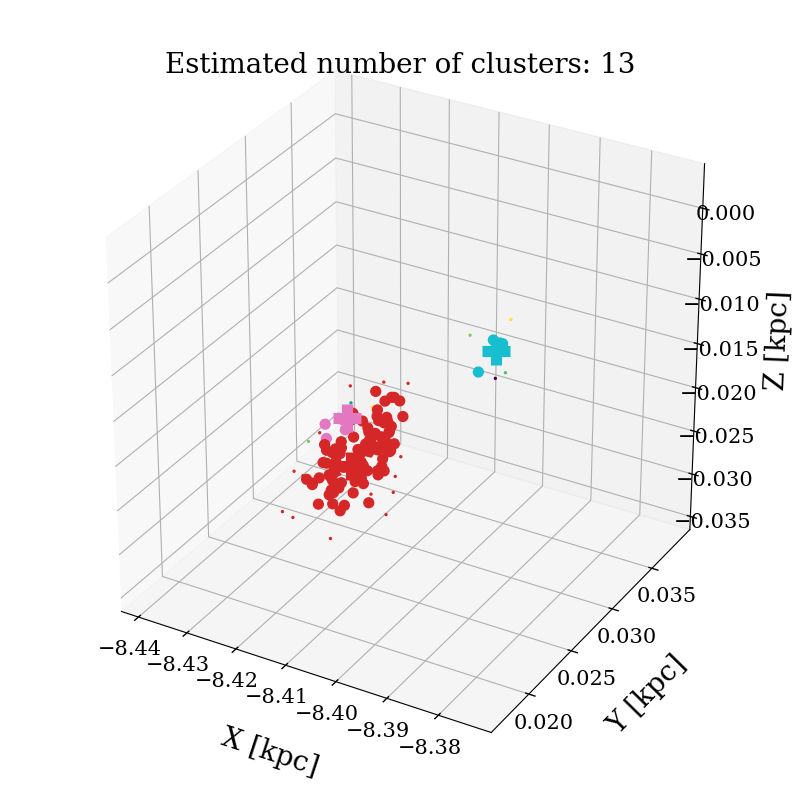

In [21]:
%matplotlib notebook
find_cluster3d(pleiades,dat,eps=.0035)

## More clusters

Try different values of `eps` and `min_samples` for the Hyades, Pleiades, and the other clusters below, to see how accurate you can get. Here are some questions to think about:
* Is there a sweet spot that works well for all of the clusters?
* Or do you have to finely tune the parameters each time? 
* Is there a quantitative way to find the best `eps` and `min_samples`?
* How would you incorporate the positional uncertainties for each star in the clustering analysis?
* Can you search through the entire dataset to find new clusters?

In [19]:
alphaper = Cluster('Alpha Persius','03h26.9m','+49d07m', .5*(.171+.200),185./60.)
coma = Cluster('Coma','12h22.5m','+25d51m',.086,7.5)
IC2391 = Cluster('IC 2391','08h40.6m','−53d02m',.175,50./60)
IC2602 = Cluster('IC 2602','10h42m57.5s','−64d23m39s',.167,50./60)